In [129]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_rolls = 10**7
attack_rolls  = np.random.randint(1, 7, size=n_rolls*3).reshape(n_rolls,3)
defense_rolls = np.random.randint(1, 7, size=n_rolls*2).reshape(n_rolls,2)

In [3]:
defense_rolls.sort(axis=1)
attack_rolls.sort(axis=1)

In [4]:
mod_attack_1 = 0
mod_attack_2 = 0
mod_defense_1 = 1
mod_defense_2 = 1

# Rolls need to be modified but can only be a max value of 6.
best_attack_rolls = np.minimum((attack_rolls[:,-1] + mod_attack_1), 6)
second_best_attack_rolls = np.minimum((attack_rolls[:,-2] + mod_attack_2), 6)

best_defense_rolls = np.minimum((defense_rolls[:,-1] + mod_defense_1), 6)
second_best_defense_rolls = np.minimum((defense_rolls[:,-2] + mod_defense_2), 6)


In [5]:
defenders_lost = (np.sum(best_attack_rolls > best_defense_rolls) +
                  np.sum(second_best_attack_rolls > second_best_defense_rolls))

attackers_lost = (np.sum(best_attack_rolls <= best_defense_rolls) +
                  np.sum(second_best_attack_rolls <= second_best_defense_rolls))

In [6]:
(defenders_lost/attackers_lost)**-1

1.8937638520858393

In [7]:
def simulate_single_battle(n_attackers=3, n_defenders=2, modifiers={'attack1':0, 'attack2':0, 'defense1':0, 'defense2':0}):
    """
    Return the result of a single simulated battle in Risk Legacy. 

    Args:
        n_attackers (int): The number of attacking troops (determines number of dice rolled).
        n_defenders (int): The number of defending troops (determines number of dice rolled).
        modifiers (dict of str: int): The modifiers to be applied to each die roll. Attack1 refers to the highest 
                                      die roll of the attacker while Attack2 is the second-highest. The same ordering 
                                      applies to the Defense1 and Defense2 keys in the modifier dict. 

    Returns:
        (int, int): A tuple containing the number of attacking troops remaining and defending troops remaining.
    """
    attackers_killed = 0
    defenders_killed = 0
    
    attack_roll  = np.random.randint(1, 7, size=min(n_attackers, 3))
    defense_roll = np.random.randint(1, 7, size=min(n_defenders, 2))

    # Sorting rolls allows us to easily find highest and second-highest rolls.
    attack_roll.sort()
    defense_roll.sort()
    
    # Need to apply modifiers to die rolls while keeping the max roll value at 6.
    modified_attack_roll1  = np.minimum((attack_roll[-1] + modifiers['attack1']), 6)
    modified_defense_roll1 = np.minimum((defense_roll[-1] + modifiers['defense1']), 6)
    
    # Compare the highest roll of the attacker and defender. Defender wins ties.
    if modified_attack_roll1 > modified_defense_roll1:
        defenders_killed += 1
    else:
        attackers_killed += 1
        
    # Compare 2nd highest die rolls if both attacker and defender used more than one die.
    if n_attackers > 1 and n_defenders > 1:
        # Only need to modify second highest rolls if we have at least 2 attacking and defending units.
        modified_attack_roll2 = np.minimum((attack_roll[-2] + modifiers['attack2']), 6)
        modified_defense_roll2 = np.minimum((defense_roll[-2] + modifiers['defense2']), 6)
        
        if modified_attack_roll2 > modified_defense_roll2:
            defenders_killed += 1
        else:
            attackers_killed += 1
        
    n_attackers_remaining = n_attackers - attackers_killed
    n_defenders_remaining = n_defenders - defenders_killed
        
    return n_attackers_remaining, n_defenders_remaining

In [8]:
simulate_single_battle(2, 2)

(0, 2)

In [9]:
def simulate_n_battles(n_attackers, n_defenders, modifiers={'attack1':0, 'attack2':0, 'defense1':0, 'defense2':0},
                       n_sims=10**4):
    
    wins = {'attacker':0, 'defender':0}
    
    for _ in range(n_sims):
        n_attack = n_attackers
        n_defend = n_defenders
        
        while n_attack > 0 and n_defend > 0:
            n_attack, n_defend = simulate_single_battle(n_attack, n_defend, modifiers)

        if n_attack > 0:
            wins['attacker'] += 1
        else:
            wins['defender'] += 1
    
    return wins

In [10]:
simulate_n_battles(18, 20, n_sims=10**4)

{'attacker': 5194, 'defender': 4806}

In [259]:
def simulate_battles_along_path(n_attackers, path, n_sims=10**4):
    n_attackers_remaining = []
    for _ in range(n_sims):
        attacking_troops = n_attackers
        for territory in path:
            # You must leave one attacker behind if you intend to advance troops after victory.
            if attacking_troops > 1:
                attacking_troops -= 1

            n_defenders = territory[0]
            modifiers = territory[1]

            while attacking_troops > 0 and n_defenders > 0:
                attacking_troops, n_defenders = simulate_single_battle(attacking_troops, n_defenders, modifiers)

        n_attackers_remaining.append(attacking_troops)

    n_attackers_remaining = np.array(n_attackers_remaining)
    return np.sum(n_attackers_remaining > 0)/n_sims

In [260]:
n_attackers = 3
default_modifiers = {'attack1':0, 'attack2':0, 'defense1':0, 'defense2':0}

path = [[20, default_modifiers], [10, default_modifiers], [5, default_modifiers]]

In [266]:
simulate_battles_along_path(n_attackers=33, path=path, n_sims=10**3)

0.505

In [167]:
n_attackers_remaining = []

n_sims = 50000
for _ in range(n_sims):
    n_attackers = 50
    for territory in path:
        # You must leave one attacker behind if you intend to advance troops after victory.
        if n_attackers > 1:
            n_attackers -= 1
            
        n_defenders = territory[0]
        modifiers = territory[1]

        while n_attackers > 0 and n_defenders > 0:
            n_attackers, n_defenders = simulate_single_battle(n_attackers, n_defenders, modifiers)
    
    n_attackers_remaining.append(n_attackers)
    
n_attackers_remaining = np.array(n_attackers_remaining)

In [168]:
expected_troops_remaining = np.mean(n_attackers_remaining)
win_percentage = np.sum(n_attackers_remaining > 0) / n_attackers_remaining.size

In [169]:
expected_troops_remaining, win_percentage

(17.88186, 0.96402)

In [170]:
n_attackers_remaining

array([ 2, 19,  0, ...,  0, 19, 30])

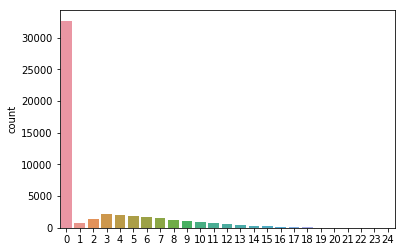

In [156]:
ax = sns.countplot(n_attackers_remaining)